In [1]:
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

from config.eval.piano import get_config as get_eval_config
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = get_eval_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
# device = torch.device(eval_cfg.device)
device = torch.device("cuda")

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
test_dataset = np.load(eval_cfg.sampler.test_dataset)
condition_dim = eval_cfg.sampler.condition_dim
descramble_key = np.loadtxt(eval_cfg.pianoroll_dataset_path + '/descramble_key.txt')

def descramble(samples):
    return descramble_key[samples.flatten()].reshape(*samples.shape)

descrambled_test_dataset = descramble(test_dataset)

2024-04-16 17:29:08.300271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 17:29:08.422365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/cudnn/8.9.0.131/lib:/usr/lib64/nvidia:/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib:/share/software/user/open/cuda/12.2.0/lib64:/share/software/user/open/cuda/12.2.0/nvvm/lib64:/share/software/user/open/cuda/12.2.0/extras/Debugger/lib64:/share/software/user/open/cuda/12.2.0/extras/CUPTI/lib64:/share/software/user/open/python/3.9.0/lib:/share/software/u

In [106]:
# -------------- Sample the model ------------------
num_samples = 5
test_data_idx = 1
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
conditioner = conditioner.repeat(num_samples, 1)
sampler = sampling_utils.get_sampler(eval_cfg)
samples, x_hist, x0_hist = sampler.sample(model, num_samples, 100, conditioner)
samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)


1000it [01:26, 11.62it/s]


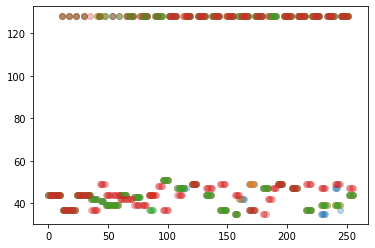

In [109]:
idx = 0
plt.scatter(np.arange(256), samples[0, :], alpha=0.3)
plt.scatter(np.arange(256), samples[1, :], alpha=0.3)
plt.scatter(np.arange(256), samples[2, :], alpha=0.3)
plt.scatter(np.arange(256), descrambled_test_dataset[test_data_idx, :], alpha=0.3)
plt.show()

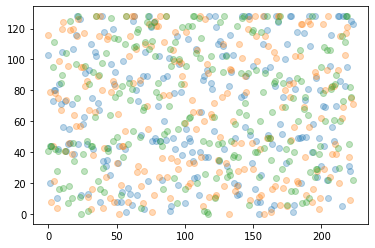

In [110]:
t = 50
plt.scatter(np.arange(224), x_hist[t, 0], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 1], alpha=0.3)
plt.scatter(np.arange(224), x_hist[t, 2], alpha=0.3)

In [4]:
def get_dist(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return np.sum(one_hot, axis=0) / L

def get_mask(seq):
    S = 129
    L = seq.shape[0]
    one_hot = np.zeros((L, S))
    seq = np.array(seq, dtype=int)
    one_hot[np.arange(L), seq] = 1
    return 1 - np.prod(1 - one_hot, axis=0)

def hellinger(seq1, seq2):
    d1, d2 = get_dist(seq1), get_dist(seq2)
    return np.sqrt(.5 * np.sum((d1 ** .5 - d2 ** .5) ** 2))

def outliers(ref, sample):
    ref_mask = get_mask(ref)
    sample_dist = get_dist(sample)
    return np.sum((1 - ref_mask) * sample_dist)

# hellinger(samples[3, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:])
# outliers(samples[3, condition_dim:], descrambled_test_dataset[test_data_idx, condition_dim:])

# Sample one sequence for each test data

In [2]:
device

device(type='cuda')

In [7]:
batch_size = 100

eval_cfg.sampler.name = "ConditionalPCTauLeapingBarker"
eval_cfg.sampler.corrector_step_size_multiplier = 0.5

sampler = sampling_utils.get_sampler(eval_cfg)
test_size = test_dataset.shape[0]
h_dists = []
outlier_proportions = []
for start in range(0, test_size, batch_size):
    print(start)
    end = min(start + batch_size, test_size)
    size = end - start
    
    conditioner = torch.from_numpy(test_dataset[start:end, :condition_dim]).to(device)
    samples, x_hist, x0_hist = sampler.sample(model, size, 1, conditioner)
    samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)

    for i in range(size):
        h = hellinger(descrambled_test_dataset[start+i, :], samples[i, :])
        r = outliers(descrambled_test_dataset[start+i, :], samples[i, :])
        h_dists.append(h)
        outlier_proportions.append(r)
        
print(eval_cfg.sampler.name)
print("Hellinger distance", np.mean(h_dists))
print("Proportion of outliers", np.mean(outlier_proportions))

0


999it [01:20, 12.46it/s]


100


999it [01:20, 12.46it/s]


200


999it [01:20, 12.46it/s]


300


999it [01:20, 12.46it/s]


400


999it [01:20, 12.46it/s]


500


999it [01:20, 12.46it/s]


600


999it [01:20, 12.46it/s]


700


999it [01:20, 12.46it/s]


800


999it [01:20, 12.46it/s]


900


999it [01:01, 16.29it/s]


ConditionalPCTauLeapingBarker
Hellinger distance 0.3763700737847883
Proportion of outliers 0.1084917780061665


In [8]:
sampler

In [155]:
# This matches the number reported in the paper
np.mean(h_dists)

0.3776880176747058

In [156]:
# And so does this...!
np.mean(outlier_proportions)

0.11121772225077081